# Evaluate results

for denoising and super resolution

In [1]:
!nvidia-smi

Tue May 18 18:41:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 307...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P0    26W /  N/A |    417MiB /  7982MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

In [3]:
import sys
sys.path.append("/src")
from src.model.skip_net import skip_net
from src.utils.data_processing import *
from src.utils.data_plotting import *

In [4]:
%config Completer.use_jedi = False

In [5]:
def convert_list_to_latex(l, mse_included=False, time_included=False):
    string = []
    for idx, elem in enumerate(l):
        dec = 2
        if mse_included:
            if idx == 0:
                dec = 5
            elif idx == 1 or idx == 2:
                dec = 3
        string.append(str(np.round(elem, decimals=dec)))
    return " & ".join(string)

In [6]:
def check_gpu():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
        try:
            tf.config.experimental.set_memory_growth(gpus[0], True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Virtual devices must be set before GPUs have been initialized
            print(e)

In [7]:
seeds = [131775, 356684, 156689]

In [8]:
def eval_history(path, experiment, num_iter=3, version="val_", time_include=True):
    
    avg_train = []
    train_time = []
    psnr_max = []
    psnr_last = []
    ssim_max = []
    ssim_last = []
    for idx in range(num_iter):
        path_eval = os.path.join(path, experiment, str(seeds[idx]), "history.csv")
        df = pd.read_csv(path_eval)
        psnr_max.append(np.max(df['{0}psnr'.format(version)]))
        psnr_last.append(df['{0}psnr'.format(version)].values[-1])
        ssim_max.append(np.max(df['{0}ssim'.format(version)]))
        ssim_last.append(df['{0}ssim'.format(version)].values[-1])
        train_time.append(df['Time'][0])
    psnr_max_mean = np.mean(psnr_max)
    psnr_last_mean = np.mean(psnr_last)
    ssim_max_mean = np.mean(ssim_max)
    ssim_last_mean = np.mean(ssim_last)
    avg_train.append(psnr_max_mean)
    avg_train.append(psnr_last_mean)
    avg_train.append(ssim_max_mean)
    avg_train.append(ssim_last_mean)
    train_time_mean = np.mean(train_time)
    if time_include:
        avg_train.append(train_time_mean)
    
    # produce output
    return experiment.replace("_", " ")+" & "+convert_list_to_latex(avg_train, 
                                                                     mse_included=False, 
                                                                     time_included=time_include)

In [9]:
def eval_history_dataset(path, experiment, num_iter=1, version="val_", time_include=True):
    ds = [os.path.join(path, d) for d in os.listdir(path)]
    result = []
    for d in ds:
        result.append([float(r) for r in eval_history(d, experiment, 1).split("&")[1:]])
    avg_train = np.mean(result, axis=0)
    return experiment.replace("_", " ")+" & "+convert_list_to_latex(avg_train, 
                                                             mse_included=False, 
                                                             time_included=time_include)

In [10]:
def eval_results(path, experiment, num_iter=3, num=0):
    
    avg_result = []
    mse_eval = []
    psnr_eval = []
    ssim_eval = []
    for idx in range(num_iter):
        path_eval = os.path.join(path, experiment, str(seeds[idx]), "results.csv")
        df = pd.read_csv(path_eval)
        mse_eval.append(df['loss'][num])
        psnr_eval.append(df['psnr'][num])
        ssim_eval.append(df['ssim'][num])
    avg_result.append(np.mean(mse_eval))
    avg_result.append(np.mean(psnr_eval))
    avg_result.append(np.mean(ssim_eval))
    
     # produce output
    return experiment.replace("_", " ")+" & "+convert_list_to_latex(avg_result, 
                                                                     mse_included=True)

In [11]:
def eval_results_dataset(path, experiment, num_iter=1, num=0):
    ds = [os.path.join(path, d) for d in os.listdir(path)]
    result = []
    for d in ds:
        result.append([float(r) for r in eval_results(d, experiment, 1).split("&")[1:]])
    avg_train = np.mean(result, axis=0)
    return experiment.replace("_", " ")+" & "+convert_list_to_latex(avg_train, 
                                                             mse_included=True)

In [12]:
def plot_history_psnr(path, experiment, num_iter=3, figsize=(10,5)):
    psnr = []
    ssim = []
    psnr2 = []
    ssim2 = []
    for idx in range(num_iter):
        path_eval = os.path.join(path, experiment, str(seeds[idx]), "history.csv")
        df = pd.read_csv(path_eval)
        psnr.append(df['{0}psnr'.format("val_")])
        ssim.append(df['{0}ssim'.format("val_")])
        psnr2.append(df['{0}psnr'.format("")])
        ssim2.append(df['{0}ssim'.format("")])
    psnr_mean = np.mean(psnr, axis=0)
    psnr_mean2 = np.mean(psnr2, axis=0)
    ssim_mean = np.mean(ssim, axis=0)
    ssim_mean2 = np.mean(ssim2, axis=0)
    fig, (ax1, ax2) = plt.subplots(2, figsize=figsize)
    ax1.plot(psnr_mean, 'b-', label="GT")
    ax1.plot(psnr_mean2, 'g-', label="Corrupted")
    ax1.set(xlabel='epochs', ylabel='PSNR')
    ax1.set_title("PSNR")
    ax1.legend()
    #plt.show()
    ax2.plot(ssim_mean, 'b-', label="GT")
    ax2.plot(ssim_mean2, 'g-', label="Corrupted")
    ax2.set(xlabel='epochs', ylabel='PSNR')
    ax2.set_title("SSIM")
    ax2.legend()
    plt.tight_layout()
    plt.show()

In [13]:
def merge(path, experiment, num_iter, num=0):
    if num==0:
        version = "val_"
    else:
        version = ""
    string1 = eval_results(path, experiment, num_iter, num=num)
    string2 = eval_history(path, experiment, num_iter, version=version)
    return string1 + " &" + "&".join(string2.split("&")[1:]) + " \\"

In [14]:
def merge_dataset(path, experiment, num_iter=1, num=0):
    if num==0:
        version = "val_"
    else:
        version = ""
    string1 = eval_results_dataset(path, experiment, num_iter, num=num)
    string2 = eval_history_dataset(path, experiment, num_iter, version=version)
    return string1 + " &" + "&".join(string2.split("&")[1:]) + " \\"

# Original data

## Denoising and Super Resolution

In [15]:
path = "train_runs/denoising/original/"

experiments = os.listdir(path)
experiments

['16_channel',
 'avg',
 '5_128_fm',
 '8_skip_connection',
 'swish_8_skip_connections',
 '4_64_fm',
 'swish_5_128_fm_8_skip',
 'mish',
 'mish_5_128_fm_8_skip',
 '5_128_fm_8_skip',
 '3_128_fm',
 '16_32_64',
 '4_32_fm',
 '16_32_64_128',
 '1_channel',
 'swish_5_128_fm',
 'relu',
 'mish_5_128_fm',
 '1_skip_connection',
 'nearest',
 'baseline',
 'mish_8_skip_connections',
 '3_channel',
 '32_64_128',
 'max',
 'swish']

In [40]:
path = "train_runs/sr/original/"

experiments = os.listdir(path)
experiments

['16_channel',
 'avg',
 '5_128_fm',
 '8_skip_connection',
 'swish_8_skip',
 '4_64_fm',
 'mish',
 '3_128_fm',
 '16_32_64',
 '4_32_fm',
 '16_32_64_128',
 '1_channel',
 'relu',
 '1_skip_connection',
 'nearest',
 'baseline',
 '3_channel',
 '32_64_128',
 'max',
 'swish']

### Combinations

In [57]:
# baseline
num = 0
print(merge(path, "baseline", 3, num=num))

baseline & 0.0045 & 23.471 & 0.678 & 23.47 & 23.33 & 0.68 & 0.68 & 306.74 \


In [58]:
# activation functions
print(merge(path, "relu", 3, num=num))
print(merge(path, "swish", 3, num=num))
print(merge(path, "mish", 3, num=num))

relu & 0.00486 & 23.138 & 0.653 & 23.14 & 22.96 & 0.65 & 0.65 & 233.84 \
swish & 0.00451 & 23.457 & 0.679 & 23.46 & 23.4 & 0.68 & 0.68 & 249.64 \
mish & 0.00463 & 23.347 & 0.674 & 23.35 & 23.27 & 0.68 & 0.67 & 256.48 \


In [59]:
# input channels
print(merge(path, "1_channel", 3, num=num))
print(merge(path, "3_channel", 3, num=num))
#print(merge(path, "8_channel", 3, num=num))
print(merge(path, "16_channel", 3, num=num))

1 channel & 0.00541 & 22.673 & 0.618 & 22.67 & 22.22 & 0.62 & 0.6 & 207.5 \
3 channel & 0.00524 & 22.805 & 0.63 & 22.81 & 20.88 & 0.64 & 0.58 & 210.88 \
16 channel & 0.00484 & 23.15 & 0.664 & 23.15 & 22.91 & 0.67 & 0.66 & 218.84 \


In [60]:
# down- and upsampling
print(merge(path, "max", 3, num=num))
print(merge(path, "avg", 3, num=num))
print(merge(path, "nearest", 3, num=num))

max & 0.00604 & 22.19 & 0.566 & 22.19 & 21.74 & 0.58 & 0.56 & 240.76 \
avg & 0.00579 & 22.374 & 0.613 & 22.37 & 21.64 & 0.62 & 0.61 & 232.28 \
nearest & 0.00631 & 22.02 & 0.578 & 22.02 & 21.55 & 0.6 & 0.59 & 225.58 \


In [61]:
# feature maps
print(merge(path, "3_128_fm", 3, num=num))
print(merge(path, "5_128_fm", 3, num=num))
print(merge(path, "4_32_fm", 3, num=num))
print(merge(path, "4_64_fm", 3, num=num))
print(merge(path, "16_32_64_128", 3, num=num))
print(merge(path, "16_32_64", 3, num=num))
print(merge(path, "32_64_128", 3, num=num))

3 128 fm & 0.00456 & 23.412 & 0.678 & 23.41 & 23.26 & 0.68 & 0.68 & 219.73 \
5 128 fm & 0.00451 & 23.462 & 0.669 & 23.46 & 23.22 & 0.67 & 0.67 & 262.09 \
4 32 fm & 0.00529 & 22.766 & 0.607 & 22.77 & 22.67 & 0.61 & 0.61 & 222.39 \
4 64 fm & 0.00494 & 23.066 & 0.645 & 23.07 & 22.95 & 0.65 & 0.64 & 242.36 \
16 32 64 128 & 0.00481 & 23.181 & 0.633 & 23.18 & 23.12 & 0.64 & 0.63 & 194.01 \
16 32 64 & 0.00528 & 22.772 & 0.593 & 22.77 & 22.59 & 0.6 & 0.59 & 152.56 \
32 64 128 & 0.00482 & 23.172 & 0.649 & 23.17 & 23.08 & 0.65 & 0.65 & 165.54 \


In [62]:
# skip connection
print(merge(path, "1_skip_connection", 3, num=num))
print(merge(path, "8_skip_connection", 3, num=num))

1 skip connection & 0.0048 & 23.186 & 0.657 & 23.19 & 22.91 & 0.66 & 0.65 & 246.74 \
8 skip connection & 0.00448 & 23.486 & 0.675 & 23.49 & 23.3 & 0.68 & 0.68 & 246.07 \


In [55]:
# combinations denoising
print(merge(path, "5_128_fm_8_skip", 3, num=num))
print(merge(path, "mish_5_128_fm", 3, num=num))
print(merge(path, "mish_5_128_fm_8_skip", 3, num=num))
print(merge(path, "mish_8_skip_connections", 3, num=num))
print(merge(path, "swish_5_128_fm", 3, num=num))
print(merge(path, "swish_5_128_fm_8_skip", 3, num=num))
print(merge(path, "swish_8_skip_connections", 3, num=num))

5 128 fm 8 skip & 0.00105 & 29.813 & 0.86 & 29.81 & 28.91 & 0.86 & 0.83 & 523.83 \
mish 5 128 fm & 0.00104 & 29.849 & 0.857 & 29.85 & 28.66 & 0.86 & 0.8 & 543.3 \
mish 5 128 fm 8 skip & 0.001 & 29.994 & 0.857 & 29.99 & 28.85 & 0.86 & 0.8 & 575.88 \
mish 8 skip connections & 0.00096 & 30.183 & 0.861 & 30.18 & 27.63 & 0.86 & 0.77 & 547.66 \
swish 5 128 fm & 0.00106 & 29.747 & 0.858 & 29.75 & 28.15 & 0.86 & 0.82 & 589.0 \
swish 5 128 fm 8 skip & 0.001 & 29.992 & 0.862 & 29.99 & 28.96 & 0.86 & 0.81 & 555.22 \
swish 8 skip connections & 0.00094 & 30.276 & 0.864 & 30.28 & 28.96 & 0.87 & 0.79 & 540.36 \


In [43]:
# combinations denoising
print(merge(path, "swish_8_skip", 3, num=0))

swish 8 skip & 0.00457 & 23.403 & 0.678 & 23.4 & 22.14 & 0.68 & 0.64 & 295.83 \


## ISBI 2012

In [110]:
path = "train_runs/denoising/ISBI_2012/"
#path = "train_runs/sr/ISBI_2012/"

experiments = os.listdir(os.path.join(path,'train-volume-3.tif'))
experiments

['5_128_fm', 'swish_8_skip', 'mish', 'baseline', '8_skip', 'swish']

In [111]:
# baseline
num = 0
print(merge_dataset(path, "baseline", 3, num=num))
print(merge_dataset(path, "swish_8_skip", 3, num=num))
print(merge_dataset(path, "swish", 3, num=num))
print(merge_dataset(path, "8_skip", 3, num=num))
print(merge_dataset(path, "5_128_fm", 3, num=num))
print(merge_dataset(path, "mish", 3, num=num))

baseline & 0.00344 & 24.909 & 0.819 & 24.91 & 24.55 & 0.82 & 0.82 & 475.06 \
swish 8 skip & 0.00285 & 25.775 & 0.841 & 25.78 & 24.23 & 0.85 & 0.8 & 527.45 \
swish & 0.00296 & 25.583 & 0.839 & 25.58 & 24.4 & 0.84 & 0.81 & 523.33 \
8 skip & 0.00325 & 25.165 & 0.829 & 25.16 & 24.69 & 0.83 & 0.82 & 475.67 \
5 128 fm & 0.00379 & 24.48 & 0.803 & 24.48 & 24.1 & 0.81 & 0.8 & 483.25 \
mish & 0.003 & 25.513 & 0.836 & 25.51 & 24.41 & 0.84 & 0.82 & 519.17 \


In [112]:
experiment = "baseline"
ds = [os.path.join(path, d) for d in os.listdir(path)]
result = []
for d in ds:
    result.append([float(r) for r in eval_results(d, experiment, 1).split("&")[1:]])

Text(0, 0.5, 'occurence')

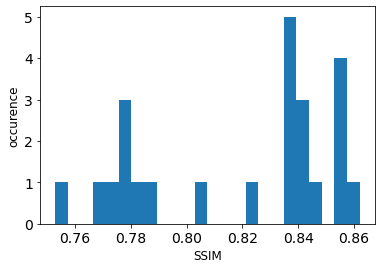

In [113]:
plt.hist(np.array(result)[:,2], bins=24)
plt.xlabel("SSIM", fontsize=12)
plt.ylabel("occurence", fontsize=12)

In [114]:
idx = np.argmin(result, axis=0)
np.min(result, axis=0)[1], idx, ds[idx[1]]

(22.351,
 array([8, 9, 7]),
 'train_runs/denoising/ISBI_2012/train-volume-21.tif')

In [115]:
result

[[0.00234, 26.302, 0.856],
 [0.00281, 25.513, 0.848],
 [0.00257, 25.897, 0.854],
 [0.00255, 25.927, 0.837],
 [0.00228, 26.412, 0.843],
 [0.00511, 22.918, 0.786],
 [0.0024, 26.197, 0.862],
 [0.00483, 23.16, 0.753],
 [0.00208, 26.813, 0.824],
 [0.00582, 22.351, 0.783],
 [0.00272, 25.647, 0.856],
 [0.00481, 23.176, 0.779],
 [0.00238, 26.24, 0.84],
 [0.00251, 25.997, 0.835],
 [0.00481, 23.179, 0.772],
 [0.0025, 26.019, 0.853],
 [0.0028, 25.521, 0.839],
 [0.0026, 25.851, 0.841],
 [0.00218, 26.609, 0.835],
 [0.00469, 23.291, 0.77],
 [0.00484, 23.155, 0.78],
 [0.00515, 22.886, 0.803],
 [0.00524, 22.806, 0.777],
 [0.00255, 25.943, 0.838]]

In [116]:
experiment = ['5_128_fm', 'swish_8_skip', 'mish', 'baseline', '8_skip', 'swish']
ds = [os.path.join(path, d) for d in os.listdir(path)]
result = []
for exp in experiment:
    result.append([float(r) for r in eval_results(ds[9], exp, 1).split("&")[1:]])

In [117]:
{exp:res for exp, res in zip(experiment, result)}

{'5_128_fm': [0.00619, 22.085, 0.77],
 'swish_8_skip': [0.00486, 23.13, 0.824],
 'mish': [0.00488, 23.112, 0.827],
 'baseline': [0.00582, 22.351, 0.783],
 '8_skip': [0.00532, 22.743, 0.796],
 'swish': [0.00489, 23.106, 0.833]}

In [118]:
experiment = ['5_128_fm', 'swish_8_skip', 'mish', 'baseline', '8_skip', 'swish']
ds = [os.path.join(path, d) for d in os.listdir(path)]
result = []
best_setting = []
for idx in range(len(ds)):
    result = []
    for exp in experiment:
        result.append([float(r) for r in eval_results(ds[idx], exp, 1).split("&")[1:]])
    best_setting.append(np.argmax(result, axis=0)[1])

(array([19.,  0.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,  1.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

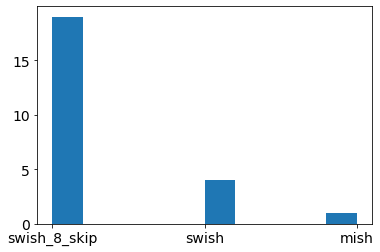

In [119]:
plt.rcParams.update({'font.size': 14})
plt.hist([experiment[sett] for sett in best_setting])

## Plot histories

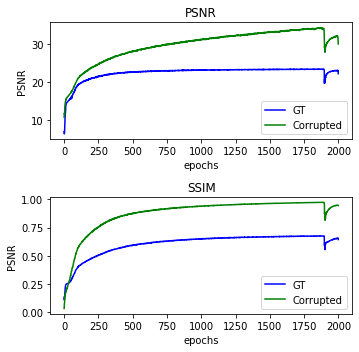

In [50]:
plot_history_psnr(path, "swish_8_skip", 3, figsize=(5,5))

# Model predict

In [40]:
check_gpu()

1 Physical GPUs, 1 Logical GPUs


In [79]:
tf.random.set_seed(131775)

# images
sigma_ = 25 / 255.
#img = load_image("data/original/F16_GT.png")
img = load_image("data/ISBI_2012/Train-Volume/train-volume-8.tif")
#img_noise = get_noise_image(img, sigma_)
#img = load_image("data/original/zebra_GT.png")
img_noise = get_low_resolution_image(img, 4)
net_img = convert_to_tf_tensor(img)
net_img_noise = convert_to_tf_tensor(img_noise)
# net input
net_input = get_network_input((1,512,512,32))

In [80]:
image_information(net_input)
image_information(img)
image_information(img_noise)

dtype:  <dtype: 'float32'> , type:  <class 'tensorflow.python.framework.ops.EagerTensor'>
size:  (1, 512, 512, 32) , range: 1.1920929132713809e-08 - 0.09999998658895493
dtype:  float32 , type:  <class 'numpy.ndarray'>
size:  (512, 512, 3) , range: 0.003921568859368563 - 0.9960784316062927
dtype:  float32 , type:  <class 'numpy.ndarray'>
size:  (128, 128, 3) , range: 0.017401961609721184 - 0.987500011920929


In [81]:
model = skip_net(input_shape=(512,512,32), activation="swish", nb_filters_skip=8)
adam = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999,
                                    epsilon=1e-08, amsgrad=False, name='Adam')
#model.compile(optimizer=adam)
model.summary()

Model: "custom_model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(1, 512, 512, 32)]  0                                            
__________________________________________________________________________________________________
reflection_padding2d_84 (Reflec (1, 514, 514, 32)    0           input[0][0]                      
__________________________________________________________________________________________________
conv2d_84 (Conv2D)              (1, 256, 256, 128)   36992       reflection_padding2d_84[0][0]    
__________________________________________________________________________________________________
batch_normalization_84 (BatchNo (1, 256, 256, 128)   512         conv2d_84[0][0]                  
_____________________________________________________________________________________

In [82]:
#model.load_weights("train_runs/denoising/original/5_128_fm/131775/model_weights.hdf5")
#model.load_weights("train_runs/denoising/ISBI_2012/train-volume-21.tif/swish_8_skip/131775/model_weights.hdf5")
#model.load_weights("train_runs/sr/original/8_skip_connection/131775/model_weights.hdf5")
model.load_weights("train_runs/sr/ISBI_2012/train-volume-8.tif/swish_8_skip/131775/model_weights.hdf5")

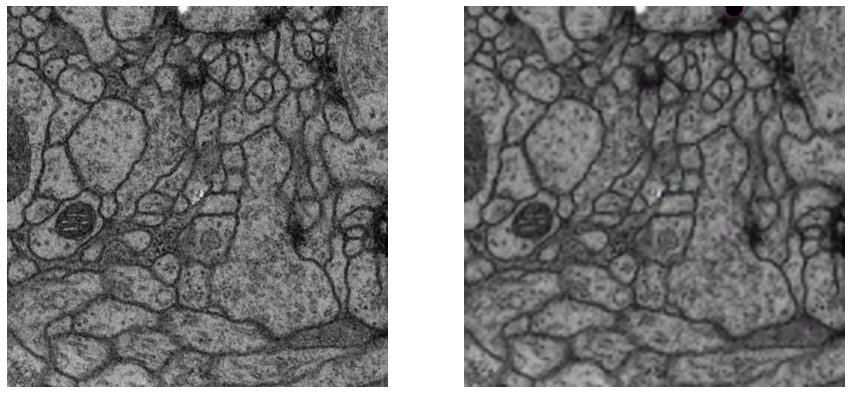

PSNR:  25.00730280865891


In [83]:
out_np = model(net_input).numpy()[0]
plot_images([img, out_np])
print("PSNR: ", peak_signal_noise_ratio(img, out_np))

In [84]:
out_np.shape

(512, 512, 3)

In [85]:
tf.image.psnr(out_np, net_img[0], max_val=1.0)

<tf.Tensor: shape=(), dtype=float32, numpy=25.007301>

In [86]:
model.compile(optimizer=adam)
model.evaluate(x = net_input,
              y= net_img)

1/1 [==============================] - 1s 621ms/step - loss: 0.0032 - psnr: 25.0073 - ssim: 0.6221


[0.0031569916754961014, 25.007265090942383, 0.6221225261688232]

Images


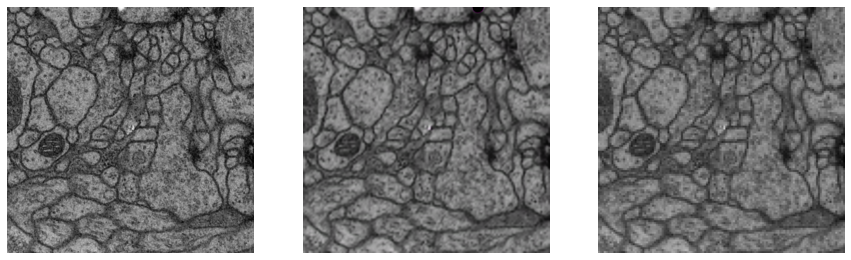

Images with cut outs


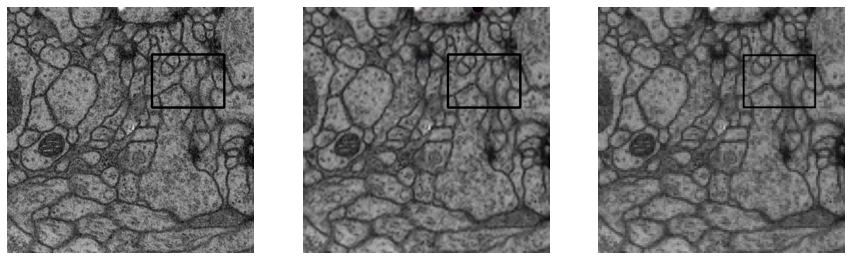

Cut outs


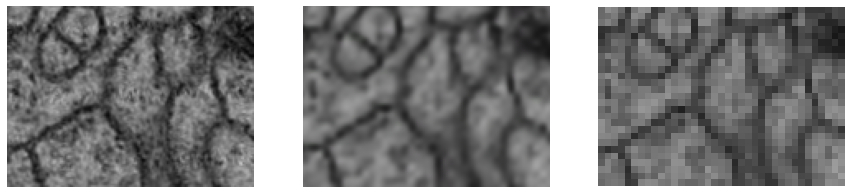

In [87]:
plot_cut_outs_different_sizes([img, out_np], [img_noise], [300,100,450,210]) #[450,180,550,250]) # 